In [3]:
%load_ext autoreload
%autoreload 2
%reset -f
from custom_imports import *
import tensorflow as tf
from tensorflow import keras

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_root = "data/"
n_muscles = 9

In [27]:
ls data/bad*

data/bad_bulk_images.set       data/bad_images.list
data/bad_enclosing_circle.set  data/bad_shapes.set


In [28]:
from functools import reduce
bad_stuff = reduce(lambda x, y: set(x) | set(y), map(joblib.load, glob.glob(data_root+"bad_im*")))

In [29]:
image_names = joblib.load(data_root+"image_names.pkl")
if n_muscles == 9:
    classes     = {k: v for k, v in joblib.load(data_root+"multi_label_images.dict").items() 
                   if k not in bad_stuff
                   and len(np.where(v==160)[0])==0
                   and len(np.where(v==150)[0])>0
                   and len(np.unique(v))==n_muscles+1 
                  }
else:
    classes     = {k: v for k, v in joblib.load(data_root+"multi_label_images.dict").items() 
                   if k not in bad_stuff
                   and len(np.where(v==150)[0])>0
                   and len(np.unique(v))==n_muscles+1 
                  }

In [30]:
raw_images  = {k: v for k, v in zip(image_names, joblib.load(data_root+"raw_images.pkl")) 
               if k not in bad_stuff and k in classes}

In [31]:
len(raw_images), len(classes)

(230, 230)

In [32]:
label = np.random.choice(list(classes.keys()))
#label = 'mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM8B/3-WM8B-16:50RepBeh.jpg'
#label = "mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Male/Subject M4/4.CO4-15:16.jpg"
y = classes[label]
x = raw_images[label]
def crop_image_and_mask(x, y):
    x = cv2.resize(x, y.shape[::-1])
    w, h = y.shape
    print(w, h)
    k = np.array([1.3/14, 2/14])
    diff = (k*y.shape).astype('int')
    xmn, ymn = np.maximum(np.array(np.where(y > 0)).min(axis=1)-diff, [0, 0])
    xmx, ymx = np.minimum(np.array(np.where(y > 0)).max(axis=1)+diff, [w, h])
    print(xmn, ymn, xmx, ymx)
    #plt.imshow(x[xmn:xmx, ymn:ymx])
    #plt.show()
    #plt.imshow(y[xmn:xmx, ymn:ymx])
    return x, y
#crop_image_and_mask(x, y)

In [114]:
def resize_mask(image, shape=(256, 256)):
    out = np.zeros(shape)
    for label in sorted(np.unique(image))[1:]:
        tmp = cv2.resize((image==label).astype('uint8'), shape[::-1])*label
        out = np.maximum(out, tmp)
    return out

def resize_iamge_and_mask(image, mask, shape=(256, 256)):
    out = np.zeros(shape)
    for label in sorted(np.unique(image))[1:]:
        tmp = cv2.resize((image==label).astype('uint8'), shape[::-1])*label
        out = np.maximum(out, tmp)
    return out

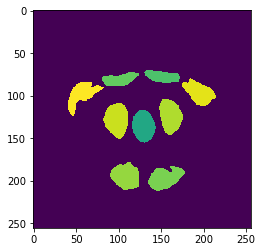

In [34]:
name = np.random.choice(list(classes.keys()))
plt.imshow(resize_mask(classes[name]))

In [35]:
client = Client(scheduler_file="/home/bzr0014/schedfile")

In [36]:
X0 = bag.from_sequence(list(raw_images.values()))
Y0 = bag.from_sequence(list(classes.values()))
XY = bag.map(crop_image_and_mask, X0, Y0)
X = XY.map(lambda x: x[0]).map(np.mean, axis=2).map(cv2.resize, (256, 256))
Y = XY.map(lambda x: x[1]).map(resize_mask, (256, 256))

In [37]:
shapes = XY.map(lambda x: x[1].shape).compute()

In [397]:
X = np.array(X.compute())
Y = np.array(Y.compute())
Y[Y>0] = Y[Y>0]/10 - 14
Y = Y.astype('uint8')

In [398]:
if len(X.shape) == 3:
    X = X.reshape(*X.shape, 1)
if len(Y.shape) == 3:
    Y = Y.reshape(*Y.shape, 1)

In [399]:
mu  = X.mean(axis=(1, 2, 3), keepdims=True)
std = X.std(axis=(1, 2, 3), keepdims=True)
X = (X-mu)/std

In [400]:
from sklearn.model_selection import train_test_split
Xtr, Xts, Ytr, Yts = train_test_split(X, (Y)*1, test_size=.2, random_state=17)

In [401]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, ReLU, BatchNormalization, Input, Concatenate, Flatten, MaxPooling2D
from tensorflow.keras import Sequential
from tensorflow.keras import Model

In [402]:
inputs = Input(shape=[256, 256, 1])
c1 = Conv2D(24, (3, 3), 1, padding='same', use_bias=False)(inputs)
c1 = MaxPooling2D()(inputs)
c1 = BatchNormalization()(c1)
c1 = ReLU()(c1)
c2 = Conv2D(48, (3, 3), 1, padding='same', use_bias=False)(c1)
c2 = MaxPooling2D()(c2)
c2 = BatchNormalization()(c2)
c2 = ReLU()(c2)
c3 = Conv2D(96, (3, 3), 1, padding='same', use_bias=False)(c2)
c3 = MaxPooling2D()(c3)
c3 = BatchNormalization()(c3)
c3 = ReLU()(c3)
c4 = Conv2DTranspose(48, (3, 3), 2, padding='same', use_bias=False)(c3)
#c4 = Concatenate()([c40, c2])
#c4 = c40 + c2
c4 = BatchNormalization()(c4)
c4 = ReLU()(c4)
c5 = Conv2DTranspose(24, (3, 3), 2, padding='same', use_bias=False)(c4)
#c5 = Concatenate()([c50, c1])
#c5 = c50 + c1
c5 = BatchNormalization()(c5)
c5 = ReLU()(c5)
c6 = Conv2DTranspose(24, (3, 3), 2, padding='same', use_bias=False)(c5)
#c6 = Concatenate()([c60, inputs])
#c6 = c60 + inputs
c6 = BatchNormalization()(c6)
c6 = ReLU()(c6)
output = Conv2D(12, (1, 1), padding='same')(c6)
model = Model(inputs=[inputs], outputs=[output])

In [403]:
input_ = tf.keras.layers.Input(shape=(None, None, 1))
x = tf.keras.layers.Conv2D(16, (3, 3), strides=2, padding="same", use_bias=False)(input_)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
s = x
x = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2D(128, (4, 4), strides=4, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Dropout(.3)(x)
x = tf.keras.layers.Conv2D(256, (1, 1), strides=1, padding="valid", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2D(12, (1, 1), strides=1, padding="valid", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=4, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=4, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=2, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x) + s
x = tf.keras.layers.Conv2DTranspose(12, (4, 4), strides=2, padding="same", activation="softmax")(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.ELU()(x)
#x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", use_bias=False)(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.ELU()(x)
#x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", use_bias=False)(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.ELU()(x)
#x = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=2, padding="same", use_bias=False)(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.ELU()(x)
model = tf.keras.Model(inputs = [input_], outputs=[x])

In [404]:
Xtr.shape, Ytr.shape, Xts.shape, Yts.shape

((269, 256, 256, 1), (269, 256, 256, 1), (68, 256, 256, 1), (68, 256, 256, 1))

In [405]:
Xtr2, Xval, Ytr2, Yval = train_test_split(Xtr, Ytr, test_size=.2, random_state=17)

In [406]:
cond = (Ytr2==0) & (np.random.rand(*Ytr2.shape)>.2)

In [407]:
Ytr2[cond] = np.random.randint(1, 12, size=cond.sum())

In [409]:
(Ytr2==0).sum()/(Ytr2>=0).sum()

0.17233893815861193

In [410]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model.compile(optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

In [419]:
model.fit(Xtr2, Ytr2, epochs=1000, validation_data=(Xval, Yval), shuffle=True, batch_size=16,
         callbacks=[
             tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30),
             tf.keras.callbacks.ModelCheckpoint("models/new_era.v03.11muscles.h5", monitor="val_loss", save_best_only=True),
         ]
        )

Train on 215 samples, validate on 54 samples
Epoch 1/1000
215/215 [==============================] - 21s 98ms/sample - loss: 2.6559 - acc: 0.0811 - val_loss: 2.5025 - val_acc: 0.0344
Epoch 2/1000
215/215 [==============================] - 13s 62ms/sample - loss: 2.6325 - acc: 0.0829 - val_loss: 2.4966 - val_acc: 0.0417
Epoch 3/1000
215/215 [==============================] - 13s 62ms/sample - loss: 2.6119 - acc: 0.0845 - val_loss: 2.4906 - val_acc: 0.0506
Epoch 4/1000
215/215 [==============================] - 13s 60ms/sample - loss: 2.5931 - acc: 0.0863 - val_loss: 2.4841 - val_acc: 0.0618
Epoch 5/1000
215/215 [==============================] - 13s 62ms/sample - loss: 2.5750 - acc: 0.0883 - val_loss: 2.4770 - val_acc: 0.0812
Epoch 6/1000
215/215 [==============================] - 13s 61ms/sample - loss: 2.5583 - acc: 0.0904 - val_loss: 2.4687 - val_acc: 0.1151
Epoch 7/1000
215/215 [==============================] - 14s 66ms/sample - loss: 2.5430 - acc: 0.0928 - val_loss: 2.4591 - val_a

Epoch 60/1000
215/215 [==============================] - 17s 77ms/sample - loss: 2.3019 - acc: 0.2456 - val_loss: 1.7184 - val_acc: 0.7929
Epoch 61/1000
215/215 [==============================] - 17s 78ms/sample - loss: 2.2995 - acc: 0.2470 - val_loss: 1.7142 - val_acc: 0.7962
Epoch 62/1000
215/215 [==============================] - 17s 77ms/sample - loss: 2.2967 - acc: 0.2492 - val_loss: 1.7114 - val_acc: 0.7950
Epoch 63/1000
215/215 [==============================] - 17s 77ms/sample - loss: 2.2949 - acc: 0.2506 - val_loss: 1.7150 - val_acc: 0.7936
Epoch 64/1000
215/215 [==============================] - 16s 75ms/sample - loss: 2.2928 - acc: 0.2523 - val_loss: 1.7095 - val_acc: 0.7926
Epoch 65/1000
215/215 [==============================] - 17s 79ms/sample - loss: 2.2904 - acc: 0.2542 - val_loss: 1.7054 - val_acc: 0.7952
Epoch 66/1000
215/215 [==============================] - 17s 78ms/sample - loss: 2.2889 - acc: 0.2554 - val_loss: 1.7009 - val_acc: 0.7897
Epoch 67/1000
215/215 [====

Epoch 119/1000
215/215 [==============================] - 17s 79ms/sample - loss: 2.2294 - acc: 0.2735 - val_loss: 1.5825 - val_acc: 0.8520
Epoch 120/1000
215/215 [==============================] - 17s 78ms/sample - loss: 2.2286 - acc: 0.2739 - val_loss: 1.5834 - val_acc: 0.8513
Epoch 121/1000
215/215 [==============================] - 16s 77ms/sample - loss: 2.2278 - acc: 0.2743 - val_loss: 1.5806 - val_acc: 0.8523
Epoch 122/1000
215/215 [==============================] - 17s 79ms/sample - loss: 2.2270 - acc: 0.2745 - val_loss: 1.5801 - val_acc: 0.8509
Epoch 123/1000
215/215 [==============================] - 17s 78ms/sample - loss: 2.2266 - acc: 0.2747 - val_loss: 1.5797 - val_acc: 0.8517
Epoch 124/1000
215/215 [==============================] - 17s 78ms/sample - loss: 2.2257 - acc: 0.2747 - val_loss: 1.5787 - val_acc: 0.8553
Epoch 125/1000
215/215 [==============================] - 17s 78ms/sample - loss: 2.2252 - acc: 0.2752 - val_loss: 1.5790 - val_acc: 0.8531
Epoch 126/1000
215/2

215/215 [==============================] - 17s 78ms/sample - loss: 2.1889 - acc: 0.2880 - val_loss: 1.5373 - val_acc: 0.8826
Epoch 236/1000
215/215 [==============================] - 17s 78ms/sample - loss: 2.1895 - acc: 0.2879 - val_loss: 1.5373 - val_acc: 0.8815
Epoch 237/1000
215/215 [==============================] - 17s 77ms/sample - loss: 2.1886 - acc: 0.2881 - val_loss: 1.5359 - val_acc: 0.8808
Epoch 238/1000
215/215 [==============================] - 17s 78ms/sample - loss: 2.1890 - acc: 0.2879 - val_loss: 1.5367 - val_acc: 0.8806
Epoch 239/1000
215/215 [==============================] - 16s 76ms/sample - loss: 2.1882 - acc: 0.2884 - val_loss: 1.5375 - val_acc: 0.8795
Epoch 240/1000
215/215 [==============================] - 17s 78ms/sample - loss: 2.1882 - acc: 0.2881 - val_loss: 1.5331 - val_acc: 0.8819
Epoch 241/1000
215/215 [==============================] - 17s 77ms/sample - loss: 2.1874 - acc: 0.2886 - val_loss: 1.5393 - val_acc: 0.8789
Epoch 242/1000
215/215 [===========

215/215 [==============================] - 16s 76ms/sample - loss: 2.1668 - acc: 0.2957 - val_loss: 1.5062 - val_acc: 0.8949
Epoch 395/1000
215/215 [==============================] - 17s 77ms/sample - loss: 2.1671 - acc: 0.2960 - val_loss: 1.5084 - val_acc: 0.8935
Epoch 396/1000
215/215 [==============================] - 16s 76ms/sample - loss: 2.1665 - acc: 0.2959 - val_loss: 1.5060 - val_acc: 0.8928
Epoch 397/1000
215/215 [==============================] - 16s 76ms/sample - loss: 2.1664 - acc: 0.2957 - val_loss: 1.5056 - val_acc: 0.8948
Epoch 398/1000
215/215 [==============================] - 16s 76ms/sample - loss: 2.1666 - acc: 0.2960 - val_loss: 1.5037 - val_acc: 0.8936
Epoch 399/1000
215/215 [==============================] - 17s 77ms/sample - loss: 2.1667 - acc: 0.2958 - val_loss: 1.5092 - val_acc: 0.8932
Epoch 400/1000
215/215 [==============================] - 17s 77ms/sample - loss: 2.1665 - acc: 0.2959 - val_loss: 1.5041 - val_acc: 0.8941
Epoch 401/1000
215/215 [===========

215/215 [==============================] - 17s 78ms/sample - loss: 2.1592 - acc: 0.2973 - val_loss: 1.4981 - val_acc: 0.8991
Epoch 511/1000
215/215 [==============================] - 16s 76ms/sample - loss: 2.1593 - acc: 0.2974 - val_loss: 1.4988 - val_acc: 0.9016
Epoch 512/1000
215/215 [==============================] - 16s 77ms/sample - loss: 2.1592 - acc: 0.2974 - val_loss: 1.4987 - val_acc: 0.8996
Epoch 513/1000
215/215 [==============================] - 16s 76ms/sample - loss: 2.1592 - acc: 0.2975 - val_loss: 1.5027 - val_acc: 0.9004
Epoch 514/1000
215/215 [==============================] - 16s 76ms/sample - loss: 2.1593 - acc: 0.2974 - val_loss: 1.4976 - val_acc: 0.8992
Epoch 515/1000
215/215 [==============================] - 17s 77ms/sample - loss: 2.1596 - acc: 0.2973 - val_loss: 1.4996 - val_acc: 0.8991
Epoch 516/1000
215/215 [==============================] - 17s 77ms/sample - loss: 2.1592 - acc: 0.2976 - val_loss: 1.5027 - val_acc: 0.8973
Epoch 517/1000
215/215 [===========

In [420]:
(Ytr2>0).sum() / (Ytr2>=0).sum()

0.8276610618413881

In [421]:
#m2 = tf.keras.models.load_model("models/new_era.v02.9muscles.h5")

In [422]:
pred.shape

(230, 256, 256, 12)

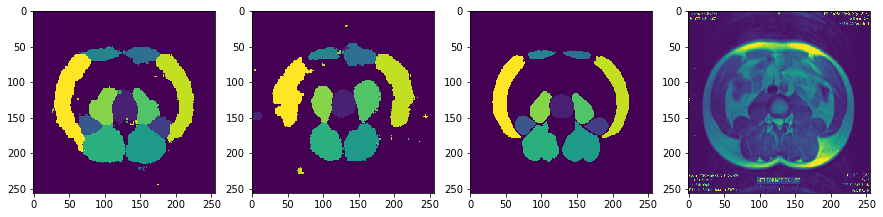

In [465]:
n = np.random.randint(len(Xts))
x = Xts[n:n+1]
res1 = model.predict(x)
res2 = m2.predict(x)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(np.argmax(res1, axis=3)[0])
axes[1].imshow(np.argmax(res2, axis=3)[0])
axes[2].imshow(Yts[n, :, :, 0])
axes[3].imshow(Xts[n, :, :, 0])

In [430]:
pred = 

68/68 [==============================] - 1s 17ms/sample - loss: 1.5261 - acc: 0.9029


[1.5260552588631124, 0.90285826]

In [456]:
m2.evaluate(Xts, Yts)

68/68 [==============================] - 2s 24ms/sample - loss: 1.6166 - acc: 0.8799


[1.616620891234454, 0.87985855]

In [318]:
ytrpred1 = model.predict(Xtr).argmax(axis=3)
ytspred1 = model.predict(Xts).argmax(axis=3)

In [329]:
mn = Xtr.min(axis=(1, 2, 3), keepdims = True)
mx = Xtr.max(axis=(1, 2, 3), keepdims = True)
ytrpred2 = m2.predict((Xtr-mn)/(mx-mn)).argmax(axis=3)
mn = Xts.min(axis=(1, 2, 3), keepdims = True)
mx = Xts.max(axis=(1, 2, 3), keepdims = True)
ytspred2 = m2.predict((Xts-mn)/(mx-mn)).argmax(axis=3)

1


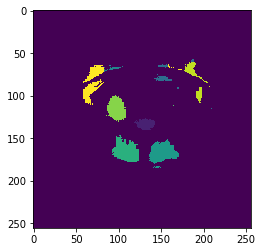

1/1 [==============================] - 0s 33ms/sample - loss: 0.1528 - acc: 0.9545
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_greater_equal_1/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/bzr0014/anaconda3/envs/tensorGpu4/lib/python3.6/site-packages/tensorflow_core/python/keras/metrics.py", line 1335, in update_state
    sample_weight=sample_weight)  File "/home/bzr0014/anaconda3/envs/tensorGpu4/lib/python3.6/site-packages/tensorflow_core/python/keras/utils/metrics_utils.py", line 304, in update_confusion_matrix_variables
    message='predictions must be <= 1')  File "/home/bzr0014/anaconda3/envs/tensorGpu4/lib/python3.6/site-packages/tensorflow_core/python/ops/check_ops.py", line 1012, in assert_greater_equal
    np.greater_equal, x, y, data, summarize, message, name)  File "

InvalidArgumentError: predictions must be <= 1
Condition x <= y did not hold element-wise:
x (Cast_9:0) = 
[0. 0. 0. ... 0. 0. 0.]
y (Cast_11/x:0) = 
1.0

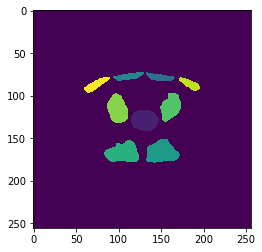

In [362]:
n = np.random.randint(len(Xts))
print(n)
pred = model.predict(Xts[n:n+1]).argmax(axis=3)
plt.imshow(pred[0])
plt.show()
plt.imshow(Yts[n, :, :, 0])
model.evaluate(Xts[n:n+1], Yts[n:n+1], )
m = tf.keras.metrics.Recall()
m.update_state(pred.reshape(-1), Yts[n].reshape(-1))

In [466]:
pred = model.predict(X, batch_size=16)

In [467]:
joblib.dump((list(raw_images.keys()), X, Y, pred), "data/predicted_11_muscles_v03.dict")

['data/predicted_11_muscles_v03.dict']

(337, 337)

114
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Female/Subject F3B/4.COF3B-14:16.jpg


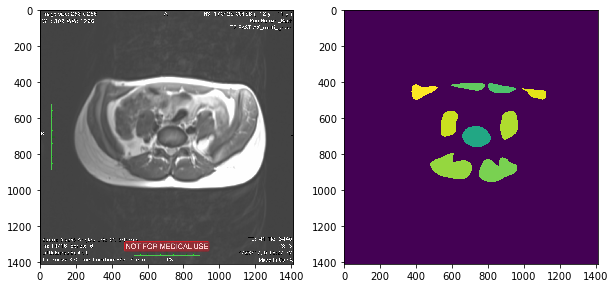

mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Male/Subject M3B/4.COM3B-14:16.jpg


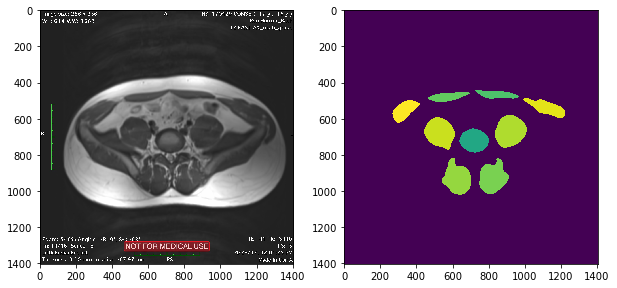

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF3B/4.WF3B-14:16.jpg


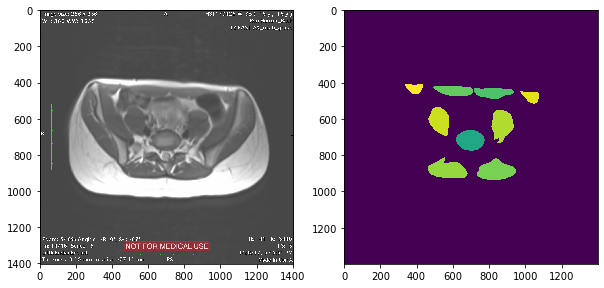

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF1B/4.WF1B-14:16.jpg


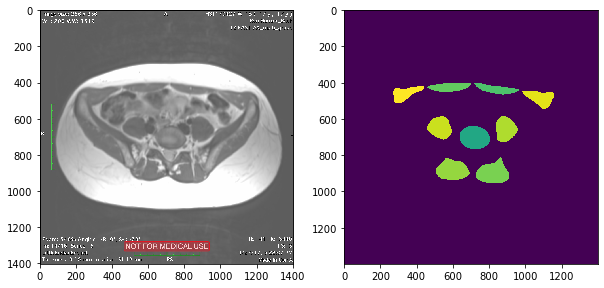

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W2B/4.WM02B-14:16.jpg


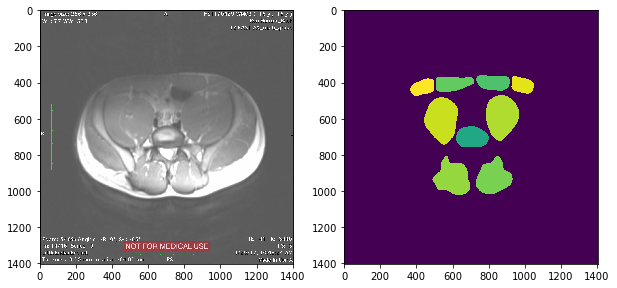

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W1B/4.WM1B-14:16.jpg


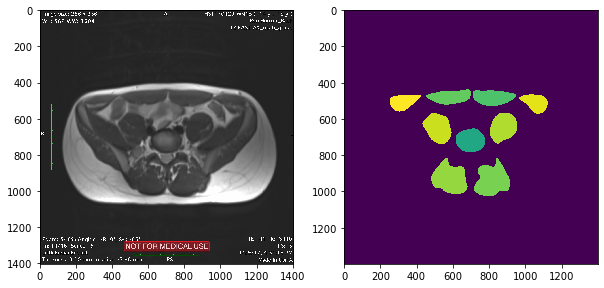

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W3B/4.WM3B-14:16.jpg


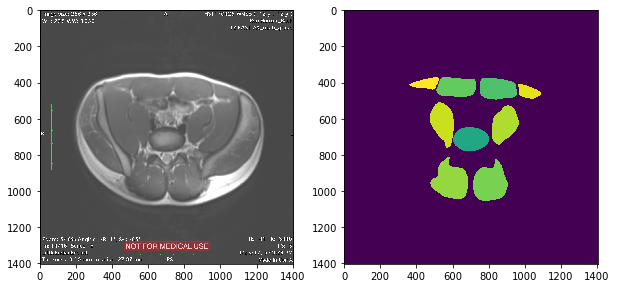

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Female/Subject WF2/4.FCWF2-14:16.jpg


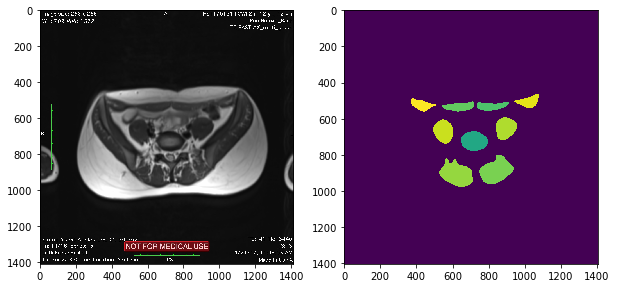

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Female/Subject WF3/4.FCWF3-14:16.jpg


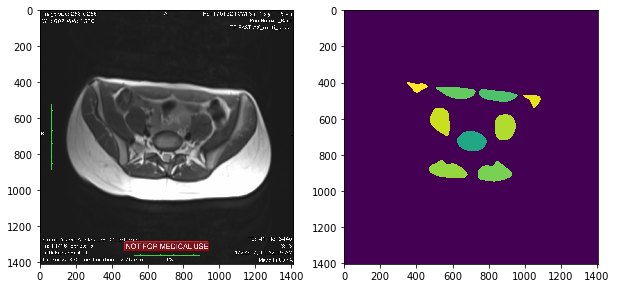

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W2/4.FCWM02-14:16.jpg


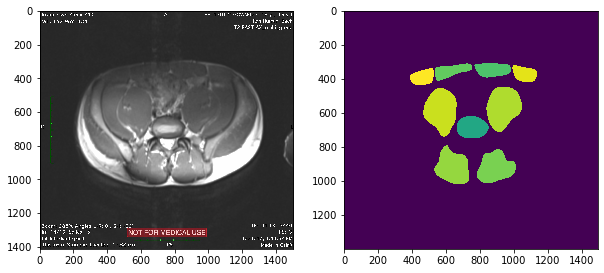

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W9/4.FCWM9-14:16.jpg


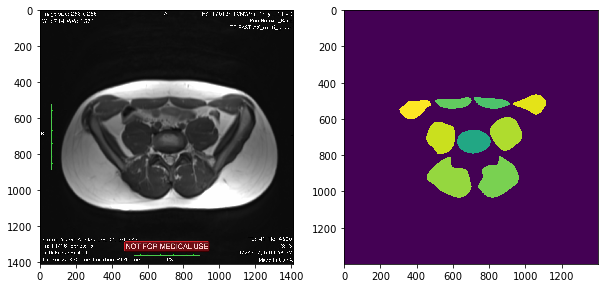

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W3/4.FCWM3-14:16.jpg


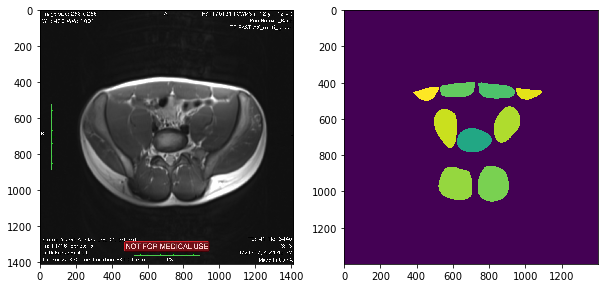

In [343]:
types = ([''.join(*re.findall("(\d).*?(\d+):", name)) for name in raw_images])
type_ = np.random.choice(types)
type_ = '114'
print(type_)
names = [name for name in raw_images if ''.join(*re.findall("(\d).*?(\d+):", name))==type_]
for name in names:
    print(name)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(raw_images[name])
    axes[1].imshow(classes[name])
    plt.show()

In [260]:
import re
import collections

Counter({'322': 5,
         '316': 10,
         '321': 3,
         '318': 2,
         '315': 6,
         '320': 3,
         '317': 1,
         '310': 1,
         '314': 1,
         '115': 22,
         '111': 2,
         '114': 12,
         '23': 12,
         '28': 2,
         '22': 2,
         '27': 5,
         '24': 1,
         '215': 1,
         '422': 5,
         '416': 11,
         '421': 4,
         '418': 2,
         '415': 6,
         '420': 3,
         '410': 2,
         '414': 1})

# Draft

In [4]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, ReLU, BatchNormalization, Input, Concatenate, Flatten, MaxPooling2D
from tensorflow.keras import Sequential
from tensorflow.keras import Model
import tensorflow as tf

In [13]:
input_ = tf.keras.layers.Input(shape=(41, 41, 1))
hidden1 = tf.keras.layers.Conv2D(16, (15, 15), use_bias=False)(input_)
bn1 = tf.keras.layers.BatchNormalization()(hidden1)
r1 = tf.keras.layers.ELU()(bn1)
hidden2 = tf.keras.layers.Conv2D(1, (15, 15), use_bias=False)(r1)
bn2 = tf.keras.layers.BatchNormalization()(hidden2)
r2 = tf.keras.layers.ELU()(bn2)
small_input = tf.keras.layers.MaxPool2D([3, 3], 3)(input_)
concat = tf.keras.layers.concatenate([small_input, r2])
d1 = tf.keras.layers.Conv2D(100, (13, 13), activation='elu', use_bias=False)(concat)
bnd1 = tf.keras.layers.BatchNormalization()(d1)
d2 = tf.keras.layers.Conv2D(50, (1, 1), activation='elu', use_bias=False)(bnd1)
bnd2 = tf.keras.layers.BatchNormalization()(d2)
out = tf.keras.layers.Conv2D(12, (1, 1), use_bias=False, activation='relu')(bnd2)
kir = Conv2DTranspose(50, (1, 1), use_bias=False)(out)
#model = tf.keras.Model(inputs = [input_], outputs=[out])

In [53]:
s

<tf.Tensor 'conv2d_144/Conv2D:0' shape=(?, 8, 8, 32) dtype=float32>

In [526]:
def dense_to_cnn(layer, inp):
    weights = layer.get_weights()[0]
    w, h = weights.shape
    k1, k2, f = inp.shape[1:]
    f = np.transpose(np.reshape(weights, (f, k1, k2, h)), [1, 2, 0, 3])
    init = tf.keras.initializers.Constant(f)
    return Conv2D(h, (k1, k2), padding="valid", activation=layer.activation,
                  use_bias=layer.use_bias, kernel_initializer=init)(inp)

In [534]:
concat = tf.keras.layers.concatenate([m.layers[6].output, m.layers[7].output])
d1 = dense_to_cnn(m.layers[11], concat)
bnd1 = m.layers[12](tf.reshape(d1, (-1, 100)))
bnd1 = tf.reshape(bnd1, (-1, 1, 1, 100))
d2 = dense_to_cnn(m.layers[13], bnd1)
bnd2 = m.layers[14](tf.reshape(d2, (-1, 50)))
bnd2 = tf.reshape(bnd2, (-1, 1, 1, 50))
out = dense_to_cnn(m.layers[15], bnd2)

In [548]:
tf.keras.Sequential([m.layers[:5]])

TypeError: The added layer must be an instance of class Layer. Found: [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x73df1d219470>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x73df1d2195f8>, <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x73df1d219ac8>, <tensorflow.python.keras.layers.advanced_activations.ELU object at 0x73df1d219cf8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x73df1d22d0f0>]

In [456]:
m.layers[1].get_weights()
bnd1 = tf.keras.layers.BatchNormalization()(d1)
d2 = tf.keras.layers.Dense(50, activation='elu', use_bias=False)(bnd1)
bnd2 = tf.keras.layers.BatchNormalization()(d2)
out = tf.keras.layers.Dense(12, use_bias=False, activation='sigmoid')(bnd2)
model = tf.keras.Model(inputs = [input_], outputs=[out])

[array([[[[ 0.4273322 , -0.66891664, -0.41082048, ...,  0.03281577,
           -0.8653048 , -0.29527175]],
 
         [[ 0.02195795, -0.26505286, -0.44935557, ..., -0.00866602,
           -0.5224701 , -0.0539092 ]],
 
         [[-0.23917915, -0.03932992, -0.3622652 , ..., -0.07664276,
           -0.32063457,  0.08171167]],
 
         ...,
 
         [[ 0.20957007, -0.07325549, -0.16613534, ..., -0.03821429,
            0.89720476,  0.80817664]],
 
         [[ 0.1956278 , -0.15037613, -0.40657434, ..., -0.09628498,
            0.7295852 ,  0.5108526 ]],
 
         [[ 0.14077339, -0.3146679 , -0.99406534, ..., -0.28412277,
            0.6733696 ,  0.19460006]]],
 
 
        [[[ 0.57008845, -0.37299308, -0.19240397, ...,  0.05940523,
           -0.6949913 , -0.33100235]],
 
         [[ 0.12794422, -0.14451392, -0.22872597, ...,  0.04517072,
           -0.49352282, -0.10632998]],
 
         [[-0.06366827,  0.023299  , -0.14730178, ...,  0.04166121,
           -0.44949096,  0.00524121]],
 


In [156]:
optimizer = tf.keras.optimizers.Nadam()
loss = tf.keras.losses.sparse_categorical_crossentropy
m.compile(optimizer, loss, metrics=['acc'])

In [100]:
t = Concatenate(axis=3)([small_input, r2])

In [102]:
Conv2D(100, (13, 13), activation="elu")(t)

<tf.Tensor 'conv2d_39/Elu:0' shape=(?, 1, 1, 100) dtype=float32>

In [390]:
weights = m.layers[-5].get_weights()[0]
weights[0].shape

(100,)

In [391]:
img1 = np.random.rand(1, 13, 13, 1).astype('float32')
img2 = np.random.rand(1, 13, 13, 1).astype('float32')

In [392]:
a = tf.keras.layers.concatenate([Flatten()(img1), Flatten()(img2)])
a = tf.matmul(a, weights)
a.shape

TensorShape([Dimension(1), Dimension(100)])

In [393]:
f = tf.transpose(tf.reshape(weights, (2, 13, 13, 100)), [1, 2, 0, 3])
b = tf.keras.layers.concatenate([img1, img2])
b = tf.nn.conv2d(b, f, 1, 'VALID')
b

<tf.Tensor 'Conv2D_69:0' shape=(1, 1, 1, 100) dtype=float32>

In [394]:
with tf.Session() as sess:
    s1, s2 = sess.run([a, b])

In [401]:
np.allclose(s1.reshape(-1), s2.reshape(-1))

False

In [399]:
(np.abs(s1-s2[0])<.001).sum()

100

In [400]:
s2.reshape(-1)

array([ 5.4061830e-01,  2.0646672e+00, -2.3464015e+00, -1.3494729e+00,
       -4.5213737e+00, -2.8847342e+00, -9.2418647e-01,  6.5814939e+00,
        2.2207770e+00, -1.6185596e+00, -5.3153901e+00,  9.5415163e-01,
        4.3815022e+00,  2.0832822e+00, -3.8332217e+00, -2.8178809e+00,
       -1.3668973e+01, -1.1041540e+01, -9.5141821e+00, -5.4392524e+00,
        1.5379860e-01,  3.3363485e+00, -7.6556144e+00, -1.7489160e+00,
       -5.6445799e+00,  3.5533617e+00, -9.0694218e+00, -1.7146657e+00,
       -1.7632019e+01,  1.4677145e-01,  4.9556785e+00,  1.0431702e-01,
        5.7244663e+00, -6.4397340e+00, -2.1240225e+00, -1.2193617e+01,
       -2.9620149e+00, -3.7888103e+00, -7.4300604e+00,  7.0919051e+00,
       -3.2518509e+01, -1.9539814e+00, -4.5014405e+00,  1.9834038e+01,
        1.4030211e+01, -2.9924273e+00, -1.0514200e+01, -1.7407287e+00,
       -3.6230798e+00,  5.6263164e-02, -1.3197096e+01, -3.7939458e+00,
       -3.0499846e-03, -9.1679363e+00,  8.0763155e-01, -4.2950649e+00,
      

In [398]:
s1.reshape(-1)

array([ 5.40618300e-01,  2.06467056e+00, -2.34640217e+00, -1.34947276e+00,
       -4.52137184e+00, -2.88473463e+00, -9.24186528e-01,  6.58149433e+00,
        2.22077632e+00, -1.61855984e+00, -5.31539011e+00,  9.54152346e-01,
        4.38150263e+00,  2.08328199e+00, -3.83322048e+00, -2.81788182e+00,
       -1.36689701e+01, -1.10415411e+01, -9.51418304e+00, -5.43925285e+00,
        1.53800324e-01,  3.33634973e+00, -7.65561485e+00, -1.74891484e+00,
       -5.64457941e+00,  3.55336332e+00, -9.06942272e+00, -1.71466541e+00,
       -1.76320210e+01,  1.46770746e-01,  4.95567846e+00,  1.04317546e-01,
        5.72446442e+00, -6.43973351e+00, -2.12402225e+00, -1.21936178e+01,
       -2.96201468e+00, -3.78880882e+00, -7.43006086e+00,  7.09190464e+00,
       -3.25185089e+01, -1.95398259e+00, -4.50144434e+00,  1.98340416e+01,
        1.40302095e+01, -2.99242806e+00, -1.05142021e+01, -1.74072933e+00,
       -3.62307954e+00,  5.62633350e-02, -1.31970949e+01, -3.79394698e+00,
       -3.05199623e-03, -

In [249]:
class MardasLoss(tf.keras.losses.Loss):
    def __init__(self, ratio, **kwargs):
        self.ratio = ratio
        super().__init__(**kwargs)
    def __call__(self, y_true, y_pred):
        y_pred = tf.where(y_true==0, y, y_pred)
        return tf.keras.losses.sparse_categorical_crossentropy(
            tf.reshape(y_true

SyntaxError: invalid syntax (<ipython-input-249-879b52c71fab>, line 6)

In [232]:
a = tf.cast(tf.random.uniform([10, 41, 41, 1]) * 5, tf.int32)
logits = tf.random.uniform([10, 41, 41, 12])

In [247]:
l1 = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
    tf.reshape(a, [-1, 1]), 
    tf.reshape(logits, [-1, 12]), from_logits=True, axis=1))
l2 = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
    tf.reshape(a, [-1, 1]), 
    tf.reshape(logits, [-1, 12]), from_logits=False, axis=1))

In [248]:
with tf.Session() as sess:
    print(sess.run([l1, l2]))

[2.5205946, 2.7614403]


In [272]:
a = np.random.randint(0, 12, [10, 41, 41, 1])
b = np.random.rand(10, 41, 41, 12)

In [274]:
s = tf.where(a==0, , tf.zeros_like(b))

ValueError: Dimension 3 in both shapes must be equal, but are 12 and 1. Shapes are [10,41,41,12] and [10,41,41,1]. for 'Select_4' (op: 'Select') with input shapes: [10,41,41,1], [10,41,41,12], [10,41,41,12].

In [265]:
with tf.Session() as sess:
    ss = s.eval()

In [269]:
(ss == 0).sum()

1367

In [270]:
(a == 0).sum()

1367

In [383]:
x = "panel_id	device_id	household_id	person_id	city	state	postal_code	country	age	gender	race".split()

In [384]:
import pandas as pd

In [385]:
pd.DataFrame(columns=x)

,panel_id,device_id,household_id,person_id,city,state,postal_code,country,age,gender,race


In [489]:
image_names = joblib.load(data_root+"image_names.pkl")
classes     = joblib.load(data_root+"multi_label_images.dict")
raw_images  = {k: v for k, v in zip(image_names, joblib.load(data_root+"raw_images.pkl")) if k in classes}

In [494]:
def crop_image_and_mask(x, y):
    x = cv2.resize(x, y.shape[::-1])
    w, h = y.shape
    k = np.array([1.3/14, 2/14])
    diff = (k*y.shape).astype('int')
    xmn, ymn = np.maximum(np.array(np.where(y > 0)).min(axis=1)-diff, [0, 0])
    xmx, ymx = np.minimum(np.array(np.where(y > 0)).max(axis=1)+diff, [w, h])
    #plt.imshow(x[xmn:xmx, ymn:ymx])
    #plt.show()
    #plt.imshow(y[xmn:xmx, ymn:ymx])
    return x, y

In [497]:
for k in classes:
    x = raw_images[k]
    y = classes[k]
    x_, y_ = crop_image_and_mask(x, y)
    print(x.shape, y.shape, x_.shape, y_.shape)
    break

(1404, 1996, 3) (1396, 1985) (1396, 1985, 3) (1396, 1985)


In [488]:
classes

dict_items([('mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/4-COF7-22:50Behnam.jpg', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)), ('mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/2-COF7-12:50Behnam.jpg', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)), ('mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/1-COF7-6:50Behnam.jpg', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)), ('mri_analysis/3.Contiguous Set#

In [475]:
len(image_names), len(classes), len(raw_images)
ls *dict

(832, 776, 832)

In [485]:
ls data

04_muti_class_cnn_v03.model  images.pkl
bad_bulk_images.set          masked/
bad_enclosing_circle.set     multi_label_images.dict
bad_images.list              predicted_04_multi_class_cnn_v03/
bad_shapes.set               predicted_11_muscles_v03.dict
bulks.dict                   predicted_9_muscles_v02.dict
cleaned_muscles.pkl          predicted_v01.dict
file_bar_length.dict         raw_images.pkl
image_names.pkl


In [484]:
mv file_bar_length.dict data

In [498]:
ls data

04_muti_class_cnn_v03.model  images.pkl
bad_bulk_images.set          masked/
bad_enclosing_circle.set     multi_label_images.dict
bad_images.list              predicted_04_multi_class_cnn_v03/
bad_shapes.set               predicted_11_muscles_v03.dict
bulks.dict                   predicted_9_muscles_v02.dict
cleaned_muscles.pkl          predicted_v01.dict
file_bar_length.dict         raw_images.pkl
image_names.pkl


In [1]:
from custom_imports import *

In [2]:
pred9  = joblib.load("data/predicted_9_muscles_v02_with_shape.tuple")
pred11 = joblib.load("data/predicted_11_muscles_v03_with_shape.tuple")

In [3]:
preds = tuple(pred9[i]+pred11[i] if isinstance(pred9, list) 
              else np.concatenate([pred9[i], pred11[i]]) for i in range(len(pred9)))

In [4]:
def resize_mask(image, shape=(256, 256)):
    out = np.zeros(shape)
    for label in sorted(np.unique(image))[1:]:
        tmp = cv2.resize((image==label).astype('uint8'), shape[::-1])*label
        out = np.maximum(out, tmp)
    return out


In [5]:
file_bar_length = joblib.load("data/file_bar_length.dict")

In [197]:
def draw_lever_arms(x, scale):
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1
    fontColor              = 13
    lineType               = 2
    w, h, *_ = x.shape
    out = x.copy()
    d = {}
    classes = sorted(np.unique(x))[1:]
    for i in classes:
        t = (x==i).astype('uint8')
        cnts = sorted(get_contours(t), key=lambda x: -len(x))[:1]
        imt = np.zeros_like(t)
        cv2.drawContours(imt, cnts, 0, int(i), -1)
        out += imt
        d[i] = cnts[0].mean(axis=(0, 1)).astype('int')
    cw, ch = d[1]
    cv2.line(out, (cw, h), (cw, 0), 13, 6)
    for i in classes[1:]:
        x, y = d[i]
        cv2.line(out, (x, y), (cw, y), 13, 6)
        value = "%4.2fcm"%(abs(x-w//2)*scale)
        cv2.putText(out, value, (x-50, y),  
                    font,  fontScale, fontColor, lineType)
    return out.astype('uint8'), d


In [52]:
n = np.random.randint(len(preds[0]))
out = [[] for _ in (preds)] + [[]]
for n in range(len(preds[0])):
    #fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    name = preds[0][n]
    print(name)
    shape = tuple(preds[4][n])
    x = preds[1][n, :, :, 0]
    y = preds[2][n, :, :, 0]
    y_pred = preds[3][n].argmax(axis=2).astype('uint8')
    x_resized = cv2.resize(x, shape[::-1])
    #ax[0].imshow(x_resized)
    y_resized = resize_mask(y, shape)
    #ax[1].imshow(y_resized)
    y_pred_resized = resize_mask(y_pred, shape)
    #ax[2].imshow(y_pred_resized)
    tmp, d = draw_lever_arms(resize_mask(y_pred, shape), 10/file_bar_length[name])
    #ax[3].imshow(tmp)
    out[0].append(name)
    out[1].append(x_resized)
    out[2].append(y_resized)
    out[3].append(y_pred_resized)
    out[4].append(tmp)
    out[5].append(d)

mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/4-COF7-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/3-COF7-17:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/4-COF5-21:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/3-COF5-16:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F2/3-COF2-17:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F2/4-COF2-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F1/4-COF1-21:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F3/3-COF3-17:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F3/4-COF3-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F4/3-COF4-15:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - 

mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/4-FCWM1-21:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/3-FCWM1-16:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/4-FCWM8-18:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/3-FCWM8-12:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/4-FCWM3-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/3-FCWM3-16:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM2/3-FCWM2-14:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM2/4-FCWM2-20:50Behnam.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F7/4.COF7-15:16.jpg
mri_analysis/1.Multigroup

mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Male/Subject M4/4-CO4-18:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Male/Subject M2/4-CO2RR-22:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Male/Subject M2/3-CO2RR-16:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F6B/3-COF6B-16:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F6B/4-COF6B-21:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F1B/4-COF1B-19:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F1B/3-COF1B-14:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F7B/4-COF7B-21:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F7B/3-COF7B-16:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F4B/3-COF4B-15:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2

mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F1/1-COF1-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F3/2-COF3-11:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F3/1-COF3-5:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F4/1-COF4-5:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F4/2-COF4-11:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F6/2-COF6-10:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F6/1-COF6-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Male/Subject M5/1-CO5-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Male/Subject M5/2-CO5-10:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Male/Subject M1/2-CO1-10:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Male/Subje

mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/1-FCWM4-2:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/2-FCWM4-8:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/1-FCWM9-1:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/2-FCWM9-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM6/1-FCWM6-1:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/1-FCWM1-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/2-FCWM1-10:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/1-FCWM8-1:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/2-FCWM3-9:50Behnam.jpg
mri_analysis/3.Contiguous S

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF6B/2.WF6B-6:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF3B/2.WF3B-7:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF3B/1.WF3B-2:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF3B/3.WF3B-10:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF2B/3.WF2B-11:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF2B/1.WF2B-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF2B/2.WF2B-7:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF4B/3.WF4B-15:50.jpg
mri_a

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W4/1.FCWM4-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W4/2.FCWM4-7:16.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Pre/Male/Subject M1/1-CO1-3:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Pre/Male/Subject M1/3-CO1-11:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/1-WM4-3:16RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F7/1-COF7-6:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F5/2-COF5-11:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F5/1-COF5-5:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F2/2-COF2-12:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F2/1-COF2-6:50Rep-Beh.jpg
mri_analysis/4.Contigu

mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Female/Subject WF1/1-FCWF1-5:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/2-FCWM4-9:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/1-FCWM4-2:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/2-FCWM9-4:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/1-FCWM9-1:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM6/1-FCWM6-1:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM6/3-FCWM6-11:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM6/2-FCWM6-5:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/1-FCWM1-4:50Beh-Rep.jpg
mri_analysis/4.C

In [519]:
import json
import shutil
def take_care_of(item, overwrite=False):
    name, x, y, ypred, ymarked, d = item
    print(name)
    basename = ''.join(name.split("/")[-1].split('.')[:-1])
    path = f"data/predictions/{basename}/"
    if os.path.exists(path):
        if overwrite:
            shutil.rmtree(path)
        else:
            return
    os.mkdir(path)
    with open(f"data/predictions/{basename}/{basename}_marked.txt", "w") as f:
        f.write(json.dumps({str(k): v.tolist() for k, v in d.items()}))
    cv2.imwrite(f"data/predictions/{basename}/{basename}_original.png", (255 * (x-x.min())/(x.max()-x.min())).astype('uint8'))
    cv2.imwrite(f"data/predictions/{basename}/{basename}_classes.png", y*10)
    cv2.imwrite(f"data/predictions/{basename}/{basename}_predicitons.png", ypred*10)
    tmp = np.array([item[-2]]*3).transpose((1, 2, 0))
    tmp[tmp[...,0]==13] = [25, 0, 0]
    cv2.imwrite(f"data/predictions/{basename}/{basename}_marked.png", tmp*10)

In [147]:
for item in zip(*out):
    take_care_of(item, overwrite=True)

mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/4-COF7-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/3-COF7-17:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/4-COF5-21:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/3-COF5-16:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F2/3-COF2-17:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F2/4-COF2-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F1/4-COF1-21:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F3/3-COF3-17:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F3/4-COF3-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F4/3-COF4-15:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - 

mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/4-FCWM1-21:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/3-FCWM1-16:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/4-FCWM8-18:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/3-FCWM8-12:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/4-FCWM3-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/3-FCWM3-16:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM2/3-FCWM2-14:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM2/4-FCWM2-20:50Behnam.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F7/4.COF7-15:16.jpg
mri_analysis/1.Multigroup

mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Male/Subject M2/4-CO2RR-22:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Male/Subject M2/3-CO2RR-16:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F6B/3-COF6B-16:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F6B/4-COF6B-21:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F1B/4-COF1B-19:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F1B/3-COF1B-14:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F7B/4-COF7B-21:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F7B/3-COF7B-16:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F4B/3-COF4B-15:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F3B/4-COF3B-21:50RepBeh.jpg
mri_analysis/4.Contiguous 

mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F3/2-COF3-11:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F3/1-COF3-5:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F4/1-COF4-5:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F4/2-COF4-11:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F6/2-COF6-10:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F6/1-COF6-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Male/Subject M5/1-CO5-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Male/Subject M5/2-CO5-10:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Male/Subject M1/2-CO1-10:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Male/Subject M1/1-CO1-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Male/Subject 

mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/2-FCWM4-8:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/1-FCWM9-1:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/2-FCWM9-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM6/1-FCWM6-1:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/1-FCWM1-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/2-FCWM1-10:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/1-FCWM8-1:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/2-FCWM3-9:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM2/2-FCWM2-9:50Behnam.jpg
mri_analysis/3.Contiguous S

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF3B/2.WF3B-7:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF3B/1.WF3B-2:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF3B/3.WF3B-10:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF2B/3.WF2B-11:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF2B/1.WF2B-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF2B/2.WF2B-7:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF4B/3.WF4B-15:50.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF4B/1.WF4B-3:50.jpg
mri_a

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W4/2.FCWM4-7:16.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Pre/Male/Subject M1/1-CO1-3:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Pre/Male/Subject M1/3-CO1-11:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/1-WM4-3:16RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F7/1-COF7-6:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F5/2-COF5-11:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F5/1-COF5-5:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F2/2-COF2-12:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F2/1-COF2-6:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F1/1-COF1-4:50Rep-Beh.jpg
mri_analysis/4.Contiguous Set#2/C

mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/2-FCWM4-9:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/1-FCWM4-2:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/2-FCWM9-4:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/1-FCWM9-1:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM6/1-FCWM6-1:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM6/3-FCWM6-11:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM6/2-FCWM6-5:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/1-FCWM1-4:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/2-FCWM1-10:50Beh-Rep.jpg
mri_analysis/4.Co

In [205]:
bars = {''.join(k.split("/")[-1].split(".")[:-1]): v for k, v in file_bar_length.items()}

data/predictions/2-CO5-10:50Rep-Beh


KeyError: 1

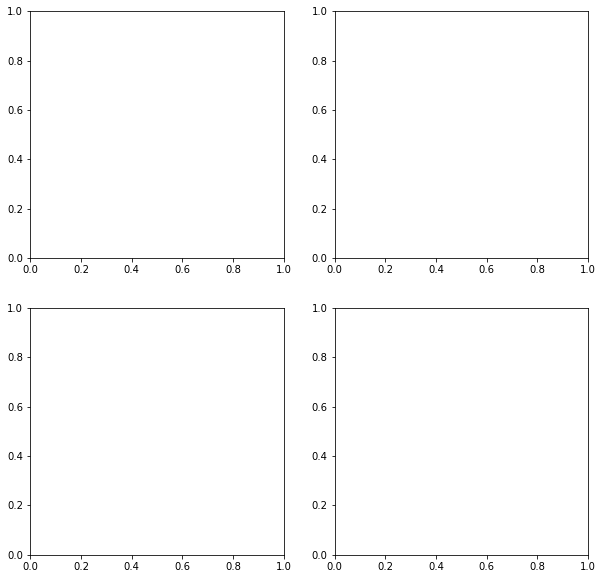

In [209]:
dr = np.random.choice(glob.glob("data/predictions/*"))
print(dr)
bar_len = bars[dr.split("/")[-1]]
files = sorted(glob.glob(f"{dr}/*png"))
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.reshape(-1)
t1, d1 = draw_lever_arms(cv2.imread(files[0], 0), 10/bar_len)
for i, f in enumerate(files):
    x = cv2.imread(f)
    axes[i].imshow(x)

In [204]:
!zip -r data/predictions.zip data/predictions/

{'4-COF7-22:50Behnam': 519,
 '2-COF7-12:50Behnam': 519,
 '1-COF7-6:50Behnam': 519,
 '3-COF7-17:50Behnam': 519,
 '1-COF5-5:50Behnam': 522,
 '4-COF5-21:50Behnam': 519,
 '2-COF5-11:50Behnam': 519,
 '3-COF5-16:50Behnam': 519,
 '1-COF2-6:50Behnam': 519,
 '3-COF2-17:50Behnam': 519,
 '4-COF2-22:50Behnam': 519,
 '2-COF2-11:50Behnam': 519,
 '3-COF1-16:50Behnam': 519,
 '2-COF1-10:50Behnam': 518,
 '1-COF1-4:50Behnam': 519,
 '4-COF1-21:50Behnam': 519,
 '2-COF3-11:50Behnam': 519,
 '3-COF3-17:50Behnam': 519,
 '1-COF3-5:50Behnam': 519,
 '4-COF3-22:50Behnam': 519,
 '4-COF4-21:50Behnam': 519,
 '1-COF4-5:50Behnam': 519,
 '3-COF4-15:50Behnam': 519,
 '2-COF4-11:50Behnam': 519,
 '3-COF6-16:50Behnam': 519,
 '2-COF6-10:50Behnam': 519,
 '4-COF6-22:50Behnam': 519,
 '1-COF6-4:50Behnam': 519,
 '3-CO3-14:50PreBeh': 517,
 '4-CO3-20:50PreBeh': 517,
 '2-CO3-8:50PreBeh': 517,
 '1-CO3-3:50PreBeh': 517,
 '3-CO5-15:50Behnam': 517,
 '1-CO5-4:50Behnam': 517,
 '2-CO5-10:50Behnam': 517,
 '4-CO5-21:50Behnam': 517,
 '2-CO1-10

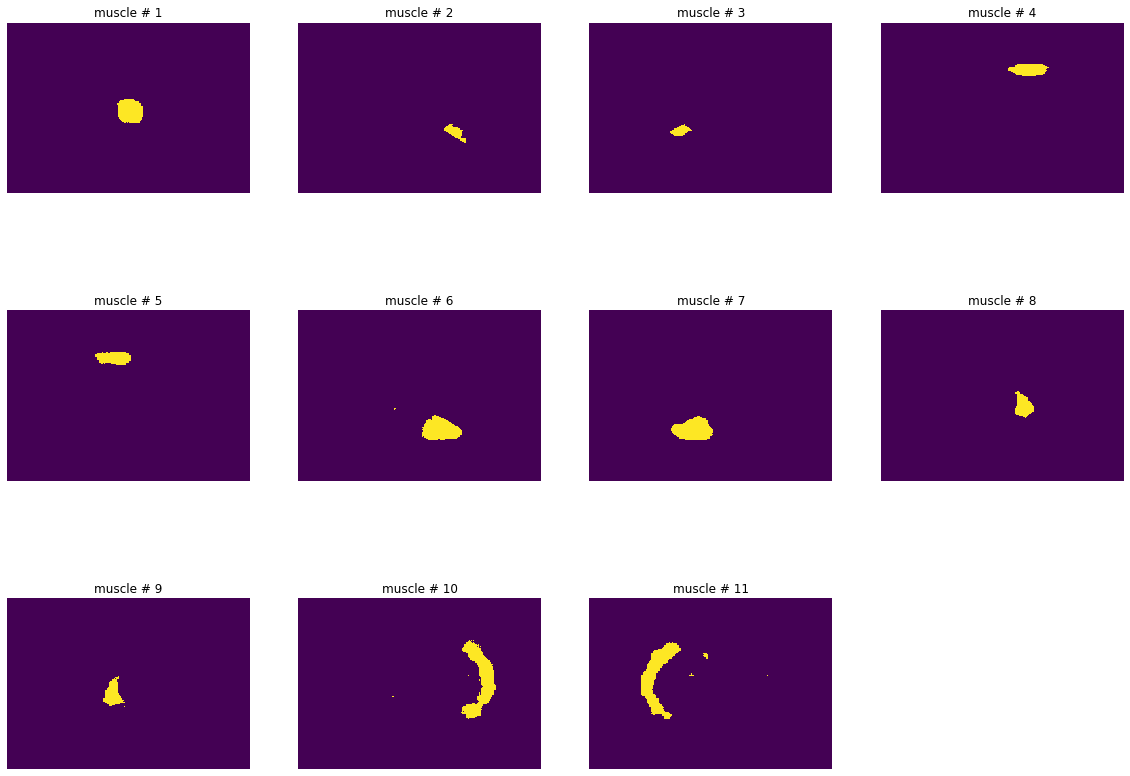

In [185]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.reshape(-1)
for i in sorted(np.unique(x))[1:]:
    axes[i//10-1].imshow(x[..., 0]==i)
    axes[i//10-1].set_title("muscle # %d"%(i//10))
    axes[i//10-1].set_axis_off()
for i in range(i//10, len(axes)):
    axes[i].set_visible(False)

In [363]:
ddata = pred9
ypred = np.array(ddata[3])
y= np.array(ddata[2])
from sklearn.model_selection import train_test_split
ytr, yts, ypredtr, ypredts = train_test_split(y, ypred, test_size=.2, random_state=17)
ytr2, yval, ypredtr2, ypredval = train_test_split(ytr, ypredtr, test_size=.2, random_state=17)

In [364]:
print(len(ytr2) + len(yts) + len(yval))
len(ytr2) + len(yts) + len(yval) == len(y)

230


True

In [365]:
def mardas(y, ypred):
    all_equal = (y[..., 0] == ypred.argmax(axis=3)).sum()
    total = (y[..., 0]>-1).sum()
    accuracy = all_equal/total
    print("accuracy: ", accuracy)
    all_equal = ((y[..., 0]>0) & (y[..., 0] == ypred.argmax(axis=3))).sum()
    total = (y[..., 0]>0).sum()
    positive_accuracy = all_equal/total
    print("positive_accuracy: ", positive_accuracy)
    all_equal = ((y[..., 0]==0) & (y[..., 0] == ypred.argmax(axis=3))).sum()
    total = (y[..., 0]==0).sum()
    negative_accuracy = all_equal/total
    print("negative_accuracy: ", negative_accuracy)
    return accuracy, positive_accuracy, negative_accuracy

In [366]:
t = mardas(y, ypred)

accuracy:  0.9370430324388587
positive_accuracy:  0.9531043657444429
negative_accuracy:  0.9350778900911819


In [367]:
tr = mardas(ytr2, ypredtr2)

accuracy:  0.9420585372821003
positive_accuracy:  0.9886742295688676
negative_accuracy:  0.9365237370004337


In [368]:
val = mardas(yval, ypredval)

accuracy:  0.9310249122413429
positive_accuracy:  0.9113600072479361
negative_accuracy:  0.9334367009285953


In [369]:
ts = mardas(yts, ypredts)

accuracy:  0.9258558853812839
positive_accuracy:  0.8819790249879164
negative_accuracy:  0.9317283259691199


In [370]:
import pandas as pd
import seaborn as sns

In [371]:
df = pd.DataFrame(np.array([t, tr, val, ts]).T, columns = ["Total", 'Train', "Val", "Test"],
                 index = ["accuracy", "positive accuracy", "negative accuracy"])

(0.87, 1)

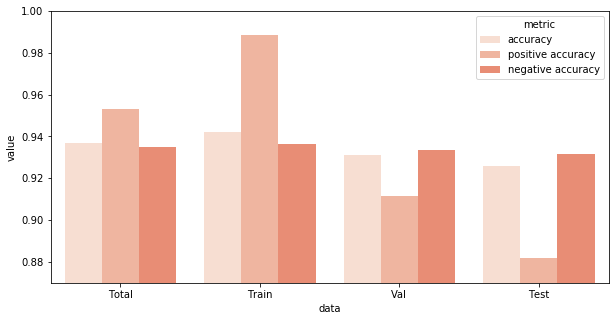

In [372]:
fig, axes = plt.subplots(figsize=(10, 5))
sns.set_palette("Reds")
df2 = df.stack().reset_index()
df2.columns = ["metric", "data", "value"]
sns.barplot(data=df2, x="data", y="value", hue="metric")
axes.set_ylim([.87, 1])

In [377]:
processed = [x.split("/")[-1] for x in glob.glob("data/predictions/*")]

In [383]:
all_files = joblib.load("data/image_names.pkl")

In [386]:
raw_images = dict(zip(all_files, joblib.load("data/raw_images.pkl")))

In [545]:
classes = joblib.load("data/multi_label_images.dict")

In [546]:
classes = {k: v for k, v in classes.items() if "".join(k.split("/")[-1].split(".")[:-1]) not in processed}

In [395]:
raw_images = {k: v for k, v in raw_images.items() 
              if "".join(k.split("/")[-1].split(".")[:-1]) not in processed 
              and k in classes}

In [486]:
len(raw_images), len(classes)

(209, 209)

In [427]:
X0 = bag.from_sequence(list(raw_images.values()))
Y0 = bag.from_sequence(list(classes.values()))
X = X0.map(cv2.resize, (256, 256))
Y = Y0.map(resize_mask, (256, 256))

In [428]:
X_, Y_ = compute(X, Y)

In [442]:
X = np.array(X_)
Y = np.array(Y_)
X = X.mean(axis=3)
X = X.reshape(*X.shape, 1)

In [444]:
X.shape, Y.shape

((209, 256, 256, 1), (209, 256, 256))

In [445]:
mu = X.mean(axis=(1, 2), keepdims=True)
std = X.std(axis=(1, 2), keepdims=True)
X = (X-mu)/std

In [408]:
m1 = tf.keras.models.load_model("models/new_era.v02.9muscles.h5")
m2 = tf.keras.models.load_model("models/new_era.v03.11muscles.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [446]:
ypred1 = m1.predict(X).argmax(axis=3)

In [447]:
ypred2 = m2.predict(X).argmax(axis=3)

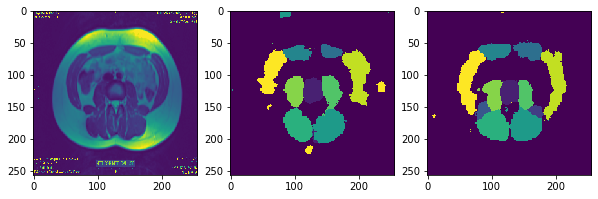

In [496]:
n = np.random.randint(len(ypred1))
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(X[n,...,0])
axes[1].imshow(ypred1[n])
axes[2].imshow(ypred2[n])

In [ ]:
import json
import shutil
def take_care_of(item, overwrite=False):

    name, x, y, ypred, ymarked, d = item

    print(name)

    basename = ''.join(name.split("/")[-1].split('.')[:-1])

    path = f"data/predictions/{basename}/"

    if os.path.exists(path):

        if overwrite:

            shutil.rmtree(path)

        else:

            return

    os.mkdir(path)

    with open(f"data/predictions/{basename}/{basename}_marked.txt", "w") as f:

        f.write(json.dumps({str(k): v.tolist() for k, v in d.items()}))

    cv2.imwrite(f"data/predictions/{basename}/{basename}_original.png", (255 * (x-x.min())/(x.max()-x.min())).astype('uint8'))

    cv2.imwrite(f"data/predictions/{basename}/{basename}_classes.png", y*10)

    cv2.imwrite(f"data/predictions/{basename}/{basename}_predicitons.png", ypred*10)

    tmp = np.array([item[-2]]*3).transpose((1, 2, 0))

    tmp[tmp[...,0]==13] = [25, 0, 0]

    cv2.imwrite(f"data/predictions/{basename}/{basename}_marked.png", tmp*10)

In [573]:
for name, x, y, yp1, yp2 in zip(raw_images.keys(), raw_images.values(), classes.values(), ypred1, ypred2):
    yp1_resized = resize_mask(yp1, x.shape[:2])
    tmp, d1 = draw_lever_arms(yp1_resized, 10/file_bar_length[name])
    tmp = np.array([tmp]*3).transpose((1, 2, 0))
    tmp[tmp[...,0]==13] = [25, 0, 0]
    tmp1 = tmp * 10
    yp2_resized = resize_mask(yp2, x.shape[:2])
    tmp, d2 = draw_lever_arms(yp2_resized, 10/file_bar_length[name])
    tmp = np.array([tmp]*3).transpose((1, 2, 0))
    tmp[tmp[...,0]==13] = [25, 0, 0]
    tmp2 = tmp * 10
    y = y.copy()
    y[y>0] = y[y>0]/10-14
    #fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    #axes[0].imshow(x)
    #axes[1].imshow(y)
    #axes[2].imshow(tmp1)
    #axes[3].imshow(tmp2)
    basename = ''.join(name.split("/")[-1].split('.')[:-1])
    path = f"data/predictions/mislabeled/{basename}/"
    print(path)
    if os.path.exists(path):
        print(f"Path {path} already exists.")
        continue
    os.mkdir(path) 
    cv2.imwrite(f"{path}/{basename}_original.png", x)
    cv2.imwrite(f"{path}/{basename}_classes.png", y*10)
    cv2.imwrite(f"{path}/{basename}_predictions1.png", yp1_resized*10)
    cv2.imwrite(f"{path}/{basename}_predictions2.png", yp2_resized*10)
    cv2.imwrite(f"{path}/{basename}_marked1.png", tmp1)
    cv2.imwrite(f"{path}/{basename}_marked2.png", tmp2)
    with open(f"{path}/{basename}_marked1.txt", "w") as f:
        f.write(json.dumps({str(k): v.tolist() for k, v in d1.items()}))
    with open(f"{path}/{basename}_marked2.txt", "w") as f:
        f.write(json.dumps({str(k): v.tolist() for k, v in d2.items()}))

data/predictions/mislabeled/3-CO3-14:50PreBeh/
data/predictions/mislabeled/4-CO3-20:50PreBeh/
data/predictions/mislabeled/2-CO3-8:50PreBeh/
data/predictions/mislabeled/2-COF6B-10:50BehnamPost/
data/predictions/mislabeled/2-WF2B-11:50Beh-Post/
data/predictions/mislabeled/3-WM4B-16:50-BehnamPost/
data/predictions/mislabeled/3-FCWM6-11:50Behnam/
data/predictions/mislabeled/2-FCWM6-5:50Behnam/
data/predictions/mislabeled/1-FCWM3-3:50Behnam/
data/predictions/mislabeled/2COF2-7:16/
data/predictions/mislabeled/3COF2-12:16/
data/predictions/mislabeled/1COF1-3:16/
data/predictions/mislabeled/1COF4-3:16/
data/predictions/mislabeled/1CO2RR-3:16/
data/predictions/mislabeled/1COF4B-3:16/
data/predictions/mislabeled/1COF2B-4:16/
data/predictions/mislabeled/4FCWF6-15:16/
data/predictions/mislabeled/1-COF7-2:16RepBeh/
data/predictions/mislabeled/4-COF7-15:16RepBeh/
data/predictions/mislabeled/2-COF7-7:16RepBeh/
data/predictions/mislabeled/3-COF5-14:16RepBeh/
data/predictions/mislabeled/2-COF5-7:16RepB

data/predictions/mislabeled/4-WF1-14:16RepBeh/
data/predictions/mislabeled/2-WF1-6:16RepBeh/
data/predictions/mislabeled/2-WM4-7:16RepBeh/
data/predictions/mislabeled/3-WM9-11:16RepBeh/
data/predictions/mislabeled/2-WM9-6:16RepBeh/
data/predictions/mislabeled/1-WM9-3:16RepBeh/
data/predictions/mislabeled/4-WM9-14:16RepBeh/
data/predictions/mislabeled/4-WM6-14:16RepBeh/
data/predictions/mislabeled/3-WM6-11:16RepBeh/
data/predictions/mislabeled/2-WM1-7:16RepBeh/
data/predictions/mislabeled/1-WM1-3:16RepBeh/
data/predictions/mislabeled/4-WM1-14:16RepBeh/
data/predictions/mislabeled/3-WM1-10:16RepBeh/
data/predictions/mislabeled/1-WM8-3:16RepBeh/
data/predictions/mislabeled/3-WM8-10:16RepBeh/
data/predictions/mislabeled/4-WM8-14:16RepBeh/
data/predictions/mislabeled/3-WM3-11:16RepBeh/
data/predictions/mislabeled/2-WM3-6:16RepBeh/
data/predictions/mislabeled/4-WM3-14:16RepBeh/
data/predictions/mislabeled/1-WM3-3:16RepBeh/
data/predictions/mislabeled/4-WM2-14:16RepBeh/
data/predictions/misla

In [572]:
mkdir "data/predictions/mislabeled/"

In [574]:
!zip -r mislabeled.zip "data/predictions/mislabeled/"

  adding: data/predictions/mislabeled/ (stored 0%)
  adding: data/predictions/mislabeled/3-WM2-11:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/3-WM2-11:16RepBeh/3-WM2-11:16RepBeh_marked1.txt (deflated 46%)
  adding: data/predictions/mislabeled/3-WM2-11:16RepBeh/3-WM2-11:16RepBeh_marked2.txt (deflated 48%)
  adding: data/predictions/mislabeled/3-WM2-11:16RepBeh/3-WM2-11:16RepBeh_predictions1.png (deflated 22%)
  adding: data/predictions/mislabeled/3-WM2-11:16RepBeh/3-WM2-11:16RepBeh_marked1.png (deflated 42%)
  adding: data/predictions/mislabeled/3-WM2-11:16RepBeh/3-WM2-11:16RepBeh_marked2.png (deflated 43%)
  adding: data/predictions/mislabeled/3-WM2-11:16RepBeh/3-WM2-11:16RepBeh_predictions2.png (deflated 26%)
  adding: data/predictions/mislabeled/3-WM2-11:16RepBeh/3-WM2-11:16RepBeh_classes.png (deflated 25%)
  adding: data/predictions/mislabeled/3-WM2-11:16RepBeh/3-WM2-11:16RepBeh_original.png (deflated 25%)
  adding: data/predictions/mislabeled/3-WF4B-15:50RepPre/ (st

  adding: data/predictions/mislabeled/1-WF4B-3:50RepPre/1-WF4B-3:50RepPre_original.png (deflated 30%)
  adding: data/predictions/mislabeled/3-WF5B-11:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/3-WF5B-11:16RepBeh/3-WF5B-11:16RepBeh_predictions2.png (deflated 22%)
  adding: data/predictions/mislabeled/3-WF5B-11:16RepBeh/3-WF5B-11:16RepBeh_marked2.png (deflated 42%)
  adding: data/predictions/mislabeled/3-WF5B-11:16RepBeh/3-WF5B-11:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/3-WF5B-11:16RepBeh/3-WF5B-11:16RepBeh_predictions1.png (deflated 28%)
  adding: data/predictions/mislabeled/3-WF5B-11:16RepBeh/3-WF5B-11:16RepBeh_original.png (deflated 23%)
  adding: data/predictions/mislabeled/3-WF5B-11:16RepBeh/3-WF5B-11:16RepBeh_marked1.png (deflated 45%)
  adding: data/predictions/mislabeled/3-WF5B-11:16RepBeh/3-WF5B-11:16RepBeh_marked1.txt (deflated 46%)
  adding: data/predictions/mislabeled/3-WF5B-11:16RepBeh/3-WF5B-11:16RepBeh_classes.png (deflate

  adding: data/predictions/mislabeled/3-COF2-12:16RepBeh/3-COF2-12:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/3-COF2-12:16RepBeh/3-COF2-12:16RepBeh_marked1.png (deflated 45%)
  adding: data/predictions/mislabeled/3-COF2-12:16RepBeh/3-COF2-12:16RepBeh_predictions1.png (deflated 25%)
  adding: data/predictions/mislabeled/3-COF2-12:16RepBeh/3-COF2-12:16RepBeh_marked2.png (deflated 47%)
  adding: data/predictions/mislabeled/3-COF2-12:16RepBeh/3-COF2-12:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/3-COF2-12:16RepBeh/3-COF2-12:16RepBeh_classes.png (deflated 35%)
  adding: data/predictions/mislabeled/1-COF2B-4:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/1-COF2B-4:16RepBeh/1-COF2B-4:16RepBeh_classes.png (deflated 32%)
  adding: data/predictions/mislabeled/1-COF2B-4:16RepBeh/1-COF2B-4:16RepBeh_marked1.png (deflated 47%)
  adding: data/predictions/mislabeled/1-COF2B-4:16RepBeh/1-COF2B-4:16RepBeh_original.png (deflated 2

  adding: data/predictions/mislabeled/2-WF3B-7:16RepBeh/2-WF3B-7:16RepBeh_predictions2.png (deflated 28%)
  adding: data/predictions/mislabeled/2-WF3B-7:16RepBeh/2-WF3B-7:16RepBeh_marked1.txt (deflated 46%)
  adding: data/predictions/mislabeled/2-WF3B-7:16RepBeh/2-WF3B-7:16RepBeh_marked1.png (deflated 47%)
  adding: data/predictions/mislabeled/2-WF3B-7:16RepBeh/2-WF3B-7:16RepBeh_marked2.png (deflated 44%)
  adding: data/predictions/mislabeled/2-WF3B-7:16RepBeh/2-WF3B-7:16RepBeh_classes.png (deflated 32%)
  adding: data/predictions/mislabeled/2-WF3B-7:16RepBeh/2-WF3B-7:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/3-COF6B-10:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/3-COF6B-10:16RepBeh/3-COF6B-10:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/3-COF6B-10:16RepBeh/3-COF6B-10:16RepBeh_predictions1.png (deflated 31%)
  adding: data/predictions/mislabeled/3-COF6B-10:16RepBeh/3-COF6B-10:16RepBeh_marked1.txt (deflated 45%

  adding: data/predictions/mislabeled/1-WF2-4:16RepBeh/1-WF2-4:16RepBeh_original.png (deflated 23%)
  adding: data/predictions/mislabeled/1-COF6-3:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/1-COF6-3:16RepBeh/1-COF6-3:16RepBeh_predictions2.png (deflated 30%)
  adding: data/predictions/mislabeled/1-COF6-3:16RepBeh/1-COF6-3:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/1-COF6-3:16RepBeh/1-COF6-3:16RepBeh_marked2.png (deflated 46%)
  adding: data/predictions/mislabeled/1-COF6-3:16RepBeh/1-COF6-3:16RepBeh_marked1.txt (deflated 46%)
  adding: data/predictions/mislabeled/1-COF6-3:16RepBeh/1-COF6-3:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/1-COF6-3:16RepBeh/1-COF6-3:16RepBeh_classes.png (deflated 29%)
  adding: data/predictions/mislabeled/1-COF6-3:16RepBeh/1-COF6-3:16RepBeh_predictions1.png (deflated 28%)
  adding: data/predictions/mislabeled/1-COF6-3:16RepBeh/1-COF6-3:16RepBeh_marked1.png (deflated 45%)
  adding: da

  adding: data/predictions/mislabeled/3-WM3B-11:16RepBeh/3-WM3B-11:16RepBeh_original.png (deflated 23%)
  adding: data/predictions/mislabeled/3-WM3B-11:16RepBeh/3-WM3B-11:16RepBeh_marked1.png (deflated 43%)
  adding: data/predictions/mislabeled/3-WM3B-11:16RepBeh/3-WM3B-11:16RepBeh_predictions1.png (deflated 25%)
  adding: data/predictions/mislabeled/4-WF5B-15:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/4-WF5B-15:16RepBeh/4-WF5B-15:16RepBeh_marked2.png (deflated 45%)
  adding: data/predictions/mislabeled/4-WF5B-15:16RepBeh/4-WF5B-15:16RepBeh_predictions1.png (deflated 30%)
  adding: data/predictions/mislabeled/4-WF5B-15:16RepBeh/4-WF5B-15:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/4-WF5B-15:16RepBeh/4-WF5B-15:16RepBeh_classes.png (deflated 41%)
  adding: data/predictions/mislabeled/4-WF5B-15:16RepBeh/4-WF5B-15:16RepBeh_marked1.txt (deflated 44%)
  adding: data/predictions/mislabeled/4-WF5B-15:16RepBeh/4-WF5B-15:16RepBeh_predictions2.png (d

  adding: data/predictions/mislabeled/2-COF2-6:16RepBeh/2-COF2-6:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/2-COF2-6:16RepBeh/2-COF2-6:16RepBeh_classes.png (deflated 38%)
  adding: data/predictions/mislabeled/2-COF2-6:16RepBeh/2-COF2-6:16RepBeh_predictions2.png (deflated 24%)
  adding: data/predictions/mislabeled/2-WF4B-9:50RepPre/ (stored 0%)
  adding: data/predictions/mislabeled/2-WF4B-9:50RepPre/2-WF4B-9:50RepPre_marked2.txt (deflated 50%)
  adding: data/predictions/mislabeled/2-WF4B-9:50RepPre/2-WF4B-9:50RepPre_predictions1.png (deflated 28%)
  adding: data/predictions/mislabeled/2-WF4B-9:50RepPre/2-WF4B-9:50RepPre_marked2.png (deflated 45%)
  adding: data/predictions/mislabeled/2-WF4B-9:50RepPre/2-WF4B-9:50RepPre_marked1.png (deflated 47%)
  adding: data/predictions/mislabeled/2-WF4B-9:50RepPre/2-WF4B-9:50RepPre_predictions2.png (deflated 28%)
  adding: data/predictions/mislabeled/2-WF4B-9:50RepPre/2-WF4B-9:50RepPre_marked1.txt (deflated 45%)
  addi

  adding: data/predictions/mislabeled/1-COF6B-3:16RepBeh/1-COF6B-3:16RepBeh_predictions1.png (deflated 26%)
  adding: data/predictions/mislabeled/1-COF6B-3:16RepBeh/1-COF6B-3:16RepBeh_marked1.txt (deflated 45%)
  adding: data/predictions/mislabeled/1-COF6B-3:16RepBeh/1-COF6B-3:16RepBeh_original.png (deflated 25%)
  adding: data/predictions/mislabeled/1-COF6B-3:16RepBeh/1-COF6B-3:16RepBeh_marked2.png (deflated 47%)
  adding: data/predictions/mislabeled/1-COF6B-3:16RepBeh/1-COF6B-3:16RepBeh_predictions2.png (deflated 31%)
  adding: data/predictions/mislabeled/1-COF6B-3:16RepBeh/1-COF6B-3:16RepBeh_marked1.png (deflated 44%)
  adding: data/predictions/mislabeled/1-COF6B-3:16RepBeh/1-COF6B-3:16RepBeh_classes.png (deflated 32%)
  adding: data/predictions/mislabeled/1-COF6B-3:16RepBeh/1-COF6B-3:16RepBeh_marked2.txt (deflated 50%)
  adding: data/predictions/mislabeled/3-WF2-11:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/3-WF2-11:16RepBeh/3-WF2-11:16RepBeh_predictions1.png (defl

  adding: data/predictions/mislabeled/2-COM5B-7:16RepBeh/2-COM5B-7:16RepBeh_marked2.png (deflated 44%)
  adding: data/predictions/mislabeled/2-COM5B-7:16RepBeh/2-COM5B-7:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/2-COM5B-7:16RepBeh/2-COM5B-7:16RepBeh_marked2.txt (deflated 50%)
  adding: data/predictions/mislabeled/2-COM5B-7:16RepBeh/2-COM5B-7:16RepBeh_predictions2.png (deflated 28%)
  adding: data/predictions/mislabeled/1-WM3-3:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/1-WM3-3:16RepBeh/1-WM3-3:16RepBeh_predictions1.png (deflated 28%)
  adding: data/predictions/mislabeled/1-WM3-3:16RepBeh/1-WM3-3:16RepBeh_marked1.txt (deflated 45%)
  adding: data/predictions/mislabeled/1-WM3-3:16RepBeh/1-WM3-3:16RepBeh_predictions2.png (deflated 26%)
  adding: data/predictions/mislabeled/1-WM3-3:16RepBeh/1-WM3-3:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/1-WM3-3:16RepBeh/1-WM3-3:16RepBeh_original.png (deflated 25%)
  adding

  adding: data/predictions/mislabeled/1-COF1-3:16RepBeh/1-COF1-3:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/1-COF1-3:16RepBeh/1-COF1-3:16RepBeh_predictions1.png (deflated 30%)
  adding: data/predictions/mislabeled/3-WM8-10:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/3-WM8-10:16RepBeh/3-WM8-10:16RepBeh_marked1.png (deflated 45%)
  adding: data/predictions/mislabeled/3-WM8-10:16RepBeh/3-WM8-10:16RepBeh_marked1.txt (deflated 45%)
  adding: data/predictions/mislabeled/3-WM8-10:16RepBeh/3-WM8-10:16RepBeh_predictions2.png (deflated 25%)
  adding: data/predictions/mislabeled/3-WM8-10:16RepBeh/3-WM8-10:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/3-WM8-10:16RepBeh/3-WM8-10:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/3-WM8-10:16RepBeh/3-WM8-10:16RepBeh_predictions1.png (deflated 30%)
  adding: data/predictions/mislabeled/3-WM8-10:16RepBeh/3-WM8-10:16RepBeh_classes.png (deflated 23%)
  add

  adding: data/predictions/mislabeled/1-FCWF3-4:50Beh-Rep/1-FCWF3-4:50Beh-Rep_original.png (deflated 26%)
  adding: data/predictions/mislabeled/1-FCWF3-4:50Beh-Rep/1-FCWF3-4:50Beh-Rep_predictions1.png (deflated 19%)
  adding: data/predictions/mislabeled/1-FCWF3-4:50Beh-Rep/1-FCWF3-4:50Beh-Rep_marked1.png (deflated 41%)
  adding: data/predictions/mislabeled/1-FCWF3-4:50Beh-Rep/1-FCWF3-4:50Beh-Rep_predictions2.png (deflated 27%)
  adding: data/predictions/mislabeled/1-FCWF3-4:50Beh-Rep/1-FCWF3-4:50Beh-Rep_marked1.txt (deflated 45%)
  adding: data/predictions/mislabeled/1-FCWF3-4:50Beh-Rep/1-FCWF3-4:50Beh-Rep_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/3-FCWM3-16:50Beh-Rep/ (stored 0%)
  adding: data/predictions/mislabeled/3-FCWM3-16:50Beh-Rep/3-FCWM3-16:50Beh-Rep_classes.png (deflated 21%)
  adding: data/predictions/mislabeled/3-FCWM3-16:50Beh-Rep/3-FCWM3-16:50Beh-Rep_marked1.txt (deflated 46%)
  adding: data/predictions/mislabeled/3-FCWM3-16:50Beh-Rep/3-FCWM3-16:50B

  adding: data/predictions/mislabeled/1-WM9B-3:16RepBeh/1-WM9B-3:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/1-WM9B-3:16RepBeh/1-WM9B-3:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/1-WM9B-3:16RepBeh/1-WM9B-3:16RepBeh_marked1.png (deflated 42%)
  adding: data/predictions/mislabeled/1-WM9B-3:16RepBeh/1-WM9B-3:16RepBeh_predictions1.png (deflated 26%)
  adding: data/predictions/mislabeled/1-WM9B-3:16RepBeh/1-WM9B-3:16RepBeh_marked2.png (deflated 44%)
  adding: data/predictions/mislabeled/4-COF1B-15:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/4-COF1B-15:16RepBeh/4-COF1B-15:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/4-COF1B-15:16RepBeh/4-COF1B-15:16RepBeh_predictions2.png (deflated 35%)
  adding: data/predictions/mislabeled/4-COF1B-15:16RepBeh/4-COF1B-15:16RepBeh_predictions1.png (deflated 32%)
  adding: data/predictions/mislabeled/4-COF1B-15:16RepBeh/4-COF1B-15:16RepBeh_marked1.txt (d

  adding: data/predictions/mislabeled/4-COM1B-15:16RepBeh/4-COM1B-15:16RepBeh_original.png (deflated 25%)
  adding: data/predictions/mislabeled/4-COM1B-15:16RepBeh/4-COM1B-15:16RepBeh_predictions1.png (deflated 31%)
  adding: data/predictions/mislabeled/3-WM4B-16:50-BehnamPost/ (stored 0%)
  adding: data/predictions/mislabeled/3-WM4B-16:50-BehnamPost/3-WM4B-16:50-BehnamPost_classes.png (deflated 19%)
  adding: data/predictions/mislabeled/3-WM4B-16:50-BehnamPost/3-WM4B-16:50-BehnamPost_marked2.png (deflated 39%)
  adding: data/predictions/mislabeled/3-WM4B-16:50-BehnamPost/3-WM4B-16:50-BehnamPost_predictions2.png (deflated 19%)
  adding: data/predictions/mislabeled/3-WM4B-16:50-BehnamPost/3-WM4B-16:50-BehnamPost_marked1.png (deflated 42%)
  adding: data/predictions/mislabeled/3-WM4B-16:50-BehnamPost/3-WM4B-16:50-BehnamPost_marked2.txt (deflated 50%)
  adding: data/predictions/mislabeled/3-WM4B-16:50-BehnamPost/3-WM4B-16:50-BehnamPost_marked1.txt (deflated 46%)
  adding: data/predictions

  adding: data/predictions/mislabeled/1-WM9-3:16RepBeh/1-WM9-3:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/1-WM9-3:16RepBeh/1-WM9-3:16RepBeh_predictions2.png (deflated 28%)
  adding: data/predictions/mislabeled/1-WM9-3:16RepBeh/1-WM9-3:16RepBeh_predictions1.png (deflated 27%)
  adding: data/predictions/mislabeled/1-WM9-3:16RepBeh/1-WM9-3:16RepBeh_marked1.txt (deflated 46%)
  adding: data/predictions/mislabeled/1-WM9-3:16RepBeh/1-WM9-3:16RepBeh_classes.png (deflated 28%)
  adding: data/predictions/mislabeled/4-WM1-14:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/4-WM1-14:16RepBeh/4-WM1-14:16RepBeh_classes.png (deflated 34%)
  adding: data/predictions/mislabeled/4-WM1-14:16RepBeh/4-WM1-14:16RepBeh_predictions1.png (deflated 31%)
  adding: data/predictions/mislabeled/4-WM1-14:16RepBeh/4-WM1-14:16RepBeh_marked1.png (deflated 46%)
  adding: data/predictions/mislabeled/4-WM1-14:16RepBeh/4-WM1-14:16RepBeh_marked2.txt (deflated 48%)
  adding: data/p

  adding: data/predictions/mislabeled/2-WM2B-7:16RepBeh/2-WM2B-7:16RepBeh_original.png (deflated 25%)
  adding: data/predictions/mislabeled/2-WM2B-7:16RepBeh/2-WM2B-7:16RepBeh_marked1.png (deflated 42%)
  adding: data/predictions/mislabeled/4-COF2-15:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/4-COF2-15:16RepBeh/4-COF2-15:16RepBeh_marked1.txt (deflated 45%)
  adding: data/predictions/mislabeled/4-COF2-15:16RepBeh/4-COF2-15:16RepBeh_marked1.png (deflated 48%)
  adding: data/predictions/mislabeled/4-COF2-15:16RepBeh/4-COF2-15:16RepBeh_classes.png (deflated 40%)
  adding: data/predictions/mislabeled/4-COF2-15:16RepBeh/4-COF2-15:16RepBeh_predictions2.png (deflated 27%)
  adding: data/predictions/mislabeled/4-COF2-15:16RepBeh/4-COF2-15:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/4-COF2-15:16RepBeh/4-COF2-15:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/4-COF2-15:16RepBeh/4-COF2-15:16RepBeh_marked2.png (deflated 43%)


  adding: data/predictions/mislabeled/2-WM9-6:16RepBeh/2-WM9-6:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/2-WM9-6:16RepBeh/2-WM9-6:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/2-WM9-6:16RepBeh/2-WM9-6:16RepBeh_predictions2.png (deflated 30%)
  adding: data/predictions/mislabeled/2-WM9-6:16RepBeh/2-WM9-6:16RepBeh_marked1.txt (deflated 45%)
  adding: data/predictions/mislabeled/4-WM3B-14:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/4-WM3B-14:16RepBeh/4-WM3B-14:16RepBeh_predictions1.png (deflated 31%)
  adding: data/predictions/mislabeled/4-WM3B-14:16RepBeh/4-WM3B-14:16RepBeh_marked1.txt (deflated 47%)
  adding: data/predictions/mislabeled/4-WM3B-14:16RepBeh/4-WM3B-14:16RepBeh_original.png (deflated 23%)
  adding: data/predictions/mislabeled/4-WM3B-14:16RepBeh/4-WM3B-14:16RepBeh_marked2.png (deflated 44%)
  adding: data/predictions/mislabeled/4-WM3B-14:16RepBeh/4-WM3B-14:16RepBeh_classes.png (deflated 31%)
  addin

  adding: data/predictions/mislabeled/4-WM1B-14:16RepBeh/4-WM1B-14:16RepBeh_original.png (deflated 23%)
  adding: data/predictions/mislabeled/4-WM1B-14:16RepBeh/4-WM1B-14:16RepBeh_predictions1.png (deflated 28%)
  adding: data/predictions/mislabeled/2-COF2B-7:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/2-COF2B-7:16RepBeh/2-COF2B-7:16RepBeh_marked2.png (deflated 43%)
  adding: data/predictions/mislabeled/2-COF2B-7:16RepBeh/2-COF2B-7:16RepBeh_predictions1.png (deflated 30%)
  adding: data/predictions/mislabeled/2-COF2B-7:16RepBeh/2-COF2B-7:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/2-COF2B-7:16RepBeh/2-COF2B-7:16RepBeh_predictions2.png (deflated 28%)
  adding: data/predictions/mislabeled/2-COF2B-7:16RepBeh/2-COF2B-7:16RepBeh_original.png (deflated 26%)
  adding: data/predictions/mislabeled/2-COF2B-7:16RepBeh/2-COF2B-7:16RepBeh_classes.png (deflated 35%)
  adding: data/predictions/mislabeled/2-COF2B-7:16RepBeh/2-COF2B-7:16RepBeh_marked1.txt (

  adding: data/predictions/mislabeled/3-WM9B-11:16RepBeh/3-WM9B-11:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/3-WM9B-11:16RepBeh/3-WM9B-11:16RepBeh_classes.png (deflated 31%)
  adding: data/predictions/mislabeled/3-WM9B-11:16RepBeh/3-WM9B-11:16RepBeh_marked1.txt (deflated 45%)
  adding: data/predictions/mislabeled/1-COM5B-3:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/1-COM5B-3:16RepBeh/1-COM5B-3:16RepBeh_marked2.txt (deflated 49%)
  adding: data/predictions/mislabeled/1-COM5B-3:16RepBeh/1-COM5B-3:16RepBeh_predictions1.png (deflated 27%)
  adding: data/predictions/mislabeled/1-COM5B-3:16RepBeh/1-COM5B-3:16RepBeh_marked1.txt (deflated 46%)
  adding: data/predictions/mislabeled/1-COM5B-3:16RepBeh/1-COM5B-3:16RepBeh_marked2.png (deflated 43%)
  adding: data/predictions/mislabeled/1-COM5B-3:16RepBeh/1-COM5B-3:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/1-COM5B-3:16RepBeh/1-COM5B-3:16RepBeh_marked1.png (deflated 4

  adding: data/predictions/mislabeled/3-COF3-11:16RepBeh/3-COF3-11:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/3-COF3-11:16RepBeh/3-COF3-11:16RepBeh_predictions2.png (deflated 28%)
  adding: data/predictions/mislabeled/3-COF3-11:16RepBeh/3-COF3-11:16RepBeh_marked2.png (deflated 44%)
  adding: data/predictions/mislabeled/3-COF3-11:16RepBeh/3-COF3-11:16RepBeh_marked1.png (deflated 45%)
  adding: data/predictions/mislabeled/3-COF3-11:16RepBeh/3-COF3-11:16RepBeh_marked1.txt (deflated 45%)
  adding: data/predictions/mislabeled/3-COF3-11:16RepBeh/3-COF3-11:16RepBeh_classes.png (deflated 34%)
  adding: data/predictions/mislabeled/3-COF3-11:16RepBeh/3-COF3-11:16RepBeh_predictions1.png (deflated 29%)
  adding: data/predictions/mislabeled/3-COF3-11:16RepBeh/3-COF3-11:16RepBeh_marked2.txt (deflated 50%)
  adding: data/predictions/mislabeled/1-COF7-2:16RepBeh/ (stored 0%)
  adding: data/predictions/mislabeled/1-COF7-2:16RepBeh/1-COF7-2:16RepBeh_predictions1.png (defl

  adding: data/predictions/mislabeled/2-COF7-7:16RepBeh/2-COF7-7:16RepBeh_original.png (deflated 24%)
  adding: data/predictions/mislabeled/2-COF7-7:16RepBeh/2-COF7-7:16RepBeh_classes.png (deflated 31%)
  adding: data/predictions/mislabeled/2-COF7-7:16RepBeh/2-COF7-7:16RepBeh_marked1.txt (deflated 45%)
  adding: data/predictions/mislabeled/2-COF7-7:16RepBeh/2-COF7-7:16RepBeh_marked2.png (deflated 43%)
  adding: data/predictions/mislabeled/2-WM6B-7:16RepPre/ (stored 0%)
  adding: data/predictions/mislabeled/2-WM6B-7:16RepPre/2-WM6B-7:16RepPre_marked2.png (deflated 46%)
  adding: data/predictions/mislabeled/2-WM6B-7:16RepPre/2-WM6B-7:16RepPre_classes.png (deflated 27%)
  adding: data/predictions/mislabeled/2-WM6B-7:16RepPre/2-WM6B-7:16RepPre_original.png (deflated 25%)
  adding: data/predictions/mislabeled/2-WM6B-7:16RepPre/2-WM6B-7:16RepPre_marked1.png (deflated 44%)
  adding: data/predictions/mislabeled/2-WM6B-7:16RepPre/2-WM6B-7:16RepPre_marked2.txt (deflated 50%)
  adding: data/predi

In [575]:
mv mislabeled.zip data/

In [580]:
center_files = glob.glob("data/predictions/*/*marked.txt")

In [695]:
def read_json(f):
    with open(f) as file:
        out = json.load(file)
    return out
res1 = [read_json(f) for f in center_files]

In [696]:
cols = columns="center mid-right mid-left top-right top-left bottom-right bottom-left center-right center-left banana-right banana-left".split()
mp = dict(enumerate(cols, 1))
res = [{mp[int(k)]: tuple(v) for k, v in t.items()} for t in res1]

In [741]:
mardas = lambda x: ''.join(''.join(x.split("/")[-1].split(".")[:-1]).split("_")[:-1])
out = pd.DataFrame(res,  )
out.columns = cols
out.index = [mardas(x) for x in center_files]

In [720]:
raw_images = dict(zip(all_files, joblib.load("data/raw_images.pkl")))
file_bar_length = joblib.load("data/file_bar_length.dict")

In [737]:
mardas = lambda x: ''.join(x.split("/")[-1].split(".")[:-1])
len(file_bar_length), len(raw_images)

(832, 832)

In [738]:
mardas(list(raw_images)[0])

'4-COF7-22:50Behnam'

In [739]:
raw_images = {mardas(k): v for k, v in raw_images.items()}
file_bar_length = {mardas(k): v for k, v in file_bar_length.items()}

In [754]:
out2 = out.copy()
cols = out2.columns
for c in cols:
    out2[c+"_x"] = out2[c].map(lambda x: x[0] if isinstance(x, tuple) else None, )
    out2[c+"_y"] = out2[c].map(lambda x: x[0] if isinstance(x, tuple) else None, )
out2 = out2.drop(cols, axis=1)
tmp = out2.index.map(file_bar_length)
out2['bar_length'] = tmp
out2['scale'] = 10/tmp

out3 = out.copy()
out3['bar_length'] = tmp
out3['scale'] = 10/tmp

In [757]:
out3.to_csv("data/centers.csv", =";")

TypeError: to_csv() got an unexpected keyword argument 'delimiter'